In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
from torchvision import transforms
import copy
import math
import pandas as pd

In [2]:
#se su colab
if not os.path.isdir('./progetto'):
    !git clone https://github.com/decoyoctopus14/progetto.git
from progetto.resnet_cifar import resnet32
from progetto.dataset import Cifar100
from progetto.utils import parameters
#altrimenti
#from resnet_cifar import resnet32

NameError: name 'os' is not defined

In [3]:
from resnet_cifar import resnet32
from dataset import Cifar100
from utils import parameters

In [16]:
#hyperparameters
LR = parameters['LR']
WEIGHT_DECAY = parameters['WEIGHT_DECAY']
BATCH_SIZE = 512
NUM_EPOCHS = parameters['NUM_EPOCHS']
DEVICE = 'cuda'
MOMENTUM=parameters['MOMENTUM']
MILESTONES=parameters['MILESTONES']
CLASSES_BATCH=parameters['CLASSES_BATCH']
NUM_CLASSES=parameters['NUM_CLASSES']
STEPDOWN_FACTOR=parameters['STEPDOWN_FACTOR']
GAMMA=parameters['GAMMA']

KeyError: 'GAMMA'

In [5]:
def kaiming_normal_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='sigmoid')



In [6]:
class LWF(nn.Module):
    def __init__(self, num_classes):
        super(LWF,self).__init__()
        self.model = resnet32()
        self.model.apply(kaiming_normal_init)
        self.model.fc = nn.Linear(64, num_classes) # Modify output layers

# Save FC layer in attributes
        self.fc = self.feature_extractor.fc
        # Save other layers in attributes
        self.feature_extractor = nn.Sequential(*list(self.model.children())[:-1])
        self.feature_extractor = nn.DataParallel(self.feature_extractor) 


        self.loss = nn.CrossEntropyLoss()
        self.dist_loss = nn.BCEWithLogitsLoss()

        self.optimizer = optim.SGD(self.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

        # n_classes is incremented before processing new data in an iteration
        # n_known is set to n_classes after all data for an iteration has been processed
        self.n_classes = 0
        self.n_known = 0
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    def increment_classes(self, new_classes):
        """Add n classes in the final fc layer"""
        n = len(new_classes)
        print('new classes: ', n)
        in_features = self.fc.in_features
        out_features = self.fc.out_features
        weight = self.fc.weight.data

        if self.n_known == 0:
            new_out_features = n
        else:
            new_out_features = out_features + n
        print('new out features: ', new_out_features)
        self.model.fc = nn.Linear(in_features, new_out_features, bias=False)
        self.fc = self.model.fc

        kaiming_normal_init(self.fc.weight)
        self.fc.weight.data[:out_features] = weight
        self.n_classes += n


In [7]:
def test(net, fc, test_dataloader):
    criterion = nn.CrossEntropyLoss()

    net.to(DEVICE)
    net.train(False)

    fc.to(DEVICE)
    fc.train(False)

    running_loss = 0.0
    running_corrects = 0
    for index, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)
        outputs = outputs.view(outputs.size(0), -1)
        outputs = fc(outputs)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate average losses
    epoch_loss = running_loss / float(len(test_dataloader.dataset))
    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataloader.dataset))

    return accuracy, epoch_loss

In [8]:
def train(net, fc, train_dataloader, test_dataloader):
    prev_net = copy.deepcopy(net).to(DEVICE)
    prev_fc = copy.deepcopy(fc).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    parameters_to_optimize = net.parameters()

    optimizer = optim.SGD(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []
    best_net = []
    best_accuracy = 0

    net.to(DEVICE)
    fc.to(DEVICE)

    for epoch in range(NUM_EPOCHS):

        if epoch in MILESTONES:
            for pg in optimizer.param_groups:
                pg['lr'] = pg['lr'] / STEPDOWN_FACTOR

        running_loss = 0.0
        running_corrects_train = 0

        for index, inputs, labels in train_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            net.train(True)
            fc.train(True)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = net(inputs)
            outputs = outputs.view(outputs.size(0), -1)
            outputs = fc(outputs)

            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects_train += torch.sum(preds == labels.data).data.item()

        # Calculate average losses
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        # Calculate accuracy
        epoch_acc = running_corrects_train / float(len(train_dataloader.dataset))

        if epoch % 10 == 0 or epoch == (NUM_EPOCHS - 1):
            print('Epoch {} Loss:{:.4f} Accuracy:{:.4f}'.format(epoch, epoch_loss, epoch_acc))
            for param_group in optimizer.param_groups:
                print('Learning rate:{}'.format(param_group['lr']))
            print('-' * 30)

        epoch_test_accuracy, epoch_test_loss = test(net, fc, test_dataloader)

        train_accuracies.append(epoch_acc)
        train_losses.append(epoch_loss)
        test_accuracies.append(epoch_test_accuracy)
        test_losses.append(epoch_test_loss)

        if epoch_test_accuracy > best_accuracy:
            best_accuracy = epoch_test_accuracy
            best_net = copy.deepcopy(net)

    return best_net, train_accuracies, train_losses, test_accuracies, test_losses

In [9]:
def update_classes(fc, new_classes):
    in_features = fc.in_features
    out_features = fc.out_features
    weight = fc.weight.data

    new_out_features = fc.out_features + len(new_classes)

    fc = nn.Linear(in_features, new_out_features, bias=False)

    fc.weight.data[:out_features] = weight

    return fc
    


In [10]:
#trasformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [11]:
def run_lwf():
    # Define transforms for training phase
   
    net = resnet32(num_classes=NUM_CLASSES)
    n_features = net.fc.in_features

    net = nn.Sequential(*list(net.children())[:-1])
    net = nn.DataParallel(net)

    fc = nn.Linear(n_features, 0, bias=False)

    new_acc_train_list = []
    new_loss_train_list = []
    new_acc_test_list = []
    new_loss_test_list = []
    all_acc_list = []

    for i in range(int(NUM_CLASSES / CLASSES_BATCH)):
        print('-' * 30)
        print(f'**** ITERATION {i + 1} ****')
        print('-' * 30)

        print('Loading the Datasets ...')
        print('-' * 30)

        train_dataset = Cifar100(classes=range(i * 10, (i + 1) * 10), train=True, transform=transform_train)
        test_dataset = Cifar100(classes=range(i * 10, (i + 1) * 10), train=False, transform=transform_test)
        
        #DEBUG
        print(len(train_dataset))
        print(i)
        print(range(i * 10, (i + 1) * 10))
        
        print('-' * 30)
        print('Training ...')
        print('-' * 30)

        # Prepare Dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
        test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

        fc = update_classes(fc, list(set(train_dataset.targets))) # <---- update classes
        net, train_accuracies, train_losses, test_accuracies, test_losses = train(net, fc, train_dataloader, test_dataloader)

        new_acc_train_list.append(train_accuracies)
        new_loss_train_list.append(train_losses)
        new_acc_test_list.append(test_accuracies)
        new_loss_test_list.append(test_losses)

        print('Testing ...')
        print('-' * 30)

        all_classes_dataset = Cifar100(classes=range(0, (i + 1) * 10), train=False, transform=transform_test)

        # Prepare Dataloader
        test_all_dataloader = DataLoader(all_classes_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

        print('All classes')

        all_acc_list.append(test(net, fc, test_all_dataloader))

        print('-' * 30)

    return new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list

In [12]:
new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list = run_lwf()

------------------------------
**** ITERATION 1 ****
------------------------------
Loading the Datasets ...
------------------------------
Files already downloaded and verified
Files already downloaded and verified
5000
0
range(0, 10)
------------------------------
Training ...
------------------------------
Epoch 0 Loss:2.1613 Accuracy:0.1378
Learning rate:2
------------------------------
Epoch 10 Loss:1.4327 Accuracy:0.4290
Learning rate:2
------------------------------
Epoch 20 Loss:1.1093 Accuracy:0.5478
Learning rate:2
------------------------------
Epoch 30 Loss:0.7922 Accuracy:0.6564
Learning rate:2
------------------------------
Epoch 40 Loss:0.6045 Accuracy:0.7208
Learning rate:2
------------------------------
Epoch 50 Loss:0.3299 Accuracy:0.8162
Learning rate:0.4
------------------------------
Epoch 60 Loss:0.2507 Accuracy:0.8486
Learning rate:0.4
------------------------------
Epoch 69 Loss:0.2071 Accuracy:0.8664
Learning rate:0.08
------------------------------
Testing ...

In [13]:
def plot_lwf(new_acc_train, new_acc_test, new_loss_train, new_loss_test, all_acc, args):
    num_epochs = len(new_acc_train[0])
    x = np.linspace(1, num_epochs, num_epochs)

    for i, (acc_train, acc_test, loss_train, loss_test) in enumerate(zip(new_acc_train, new_acc_test, new_loss_train, new_loss_test)):

        title = 'Accuracy dataset # %d - BATCH_SIZE= %d LR= %f  EPOCHS= %d  GAMMA= %f' \
                % (i + 1, args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'], args['GAMMA'])
        title2 = 'Loss dataset # %d - BATCH_SIZE= %d LR= %f  EPOCHS= %d  GAMMA= %f' \
                 % (i + 1, args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'], args['GAMMA'])

        plt.plot(x, acc_train, color='green')
        plt.plot(x, acc_test, color='darkorange')
        plt.title(title)
        plt.xticks(np.arange(1, num_epochs, 4))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train accuracy', 'Test accuracy'], loc='best')
        plt.show()

        plt.plot(x, loss_train, color='green')
        plt.plot(x, loss_test, color='darkorange')
        plt.title(title2)
        plt.xticks(np.arange(1, num_epochs, 4))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train loss', 'Test loss'], loc='best')
        plt.show()
    x=[1,2,3,4,5,6,7,8,9,10]
    plt.plot(x, np.array(all_acc)[:,0], color='lightseagreen')
    plt.title('%s incremental learning accuracy' % (args['name']))
    plt.xticks(np.arange(1, len(all_acc), 1))
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend(['Test accuracy'], loc='best')
    plt.show()

    csv_name = '{}_batch-size-{}_lr-{}_epochs-{}_gamma-{}' .format(args['name'], args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'], args['GAMMA']) 
    pd.DataFrame(all_acc).to_csv('./Results/{}.csv' .format (csv_name))

    print('Accuracy last test', new_acc_test[-1])

### PLOT

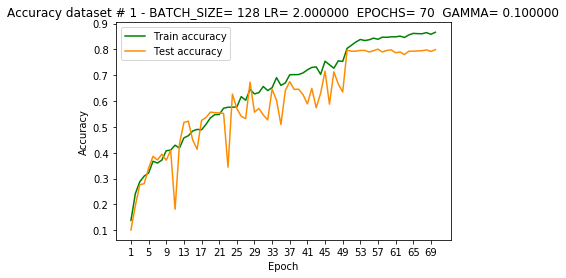

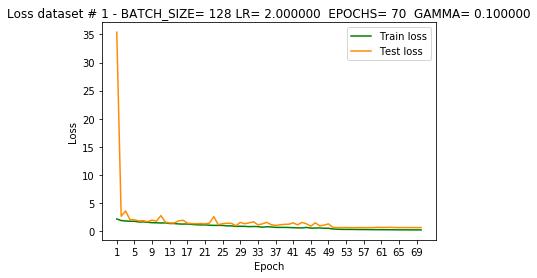

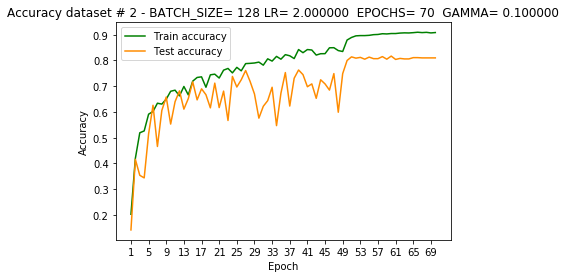

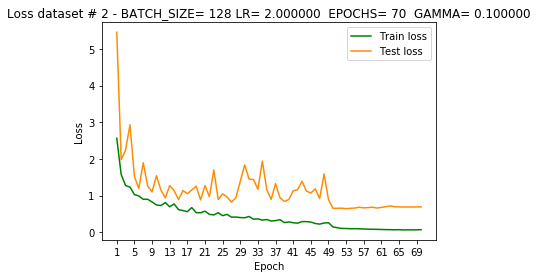

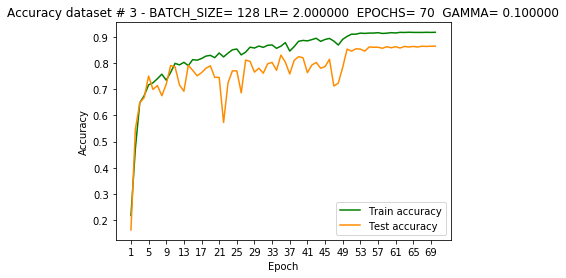

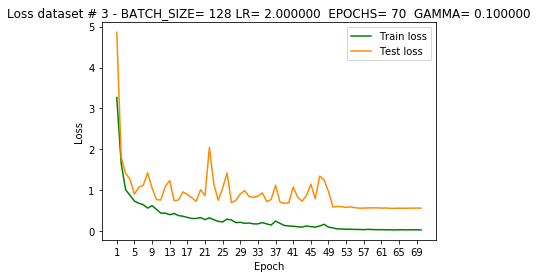

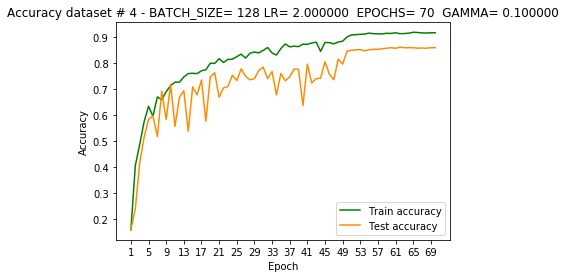

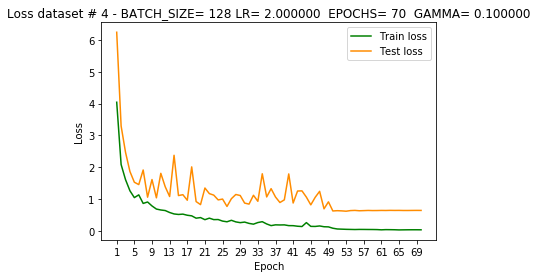

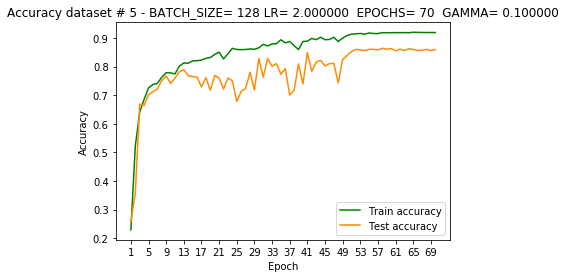

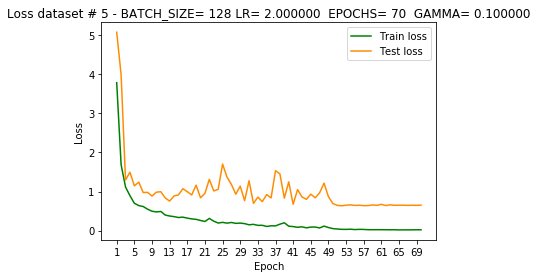

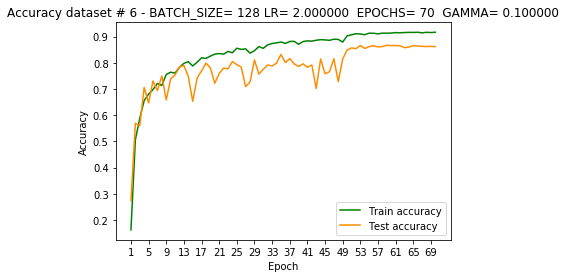

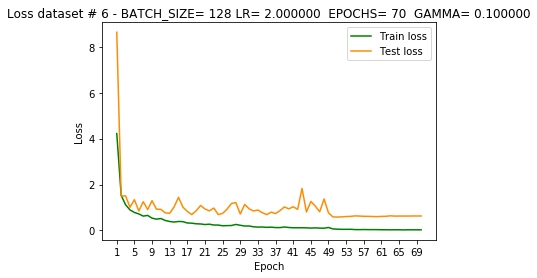

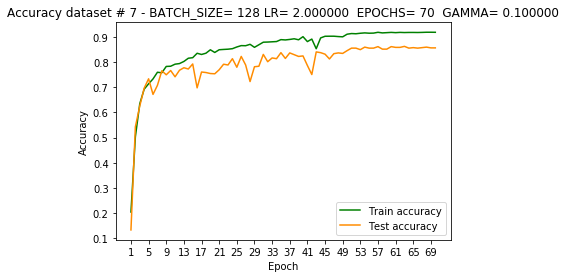

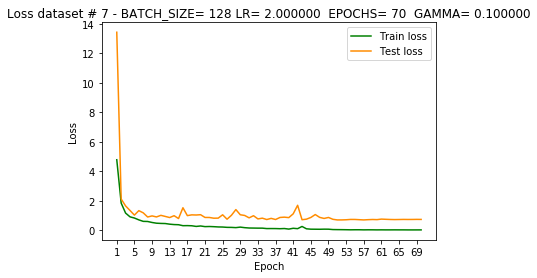

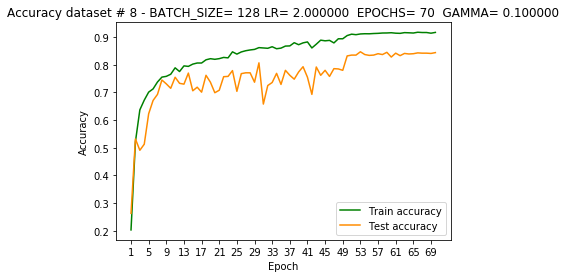

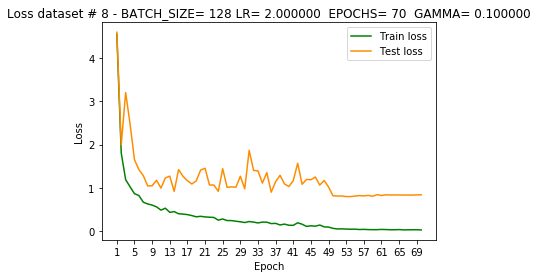

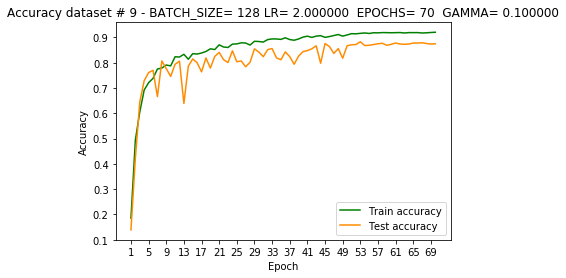

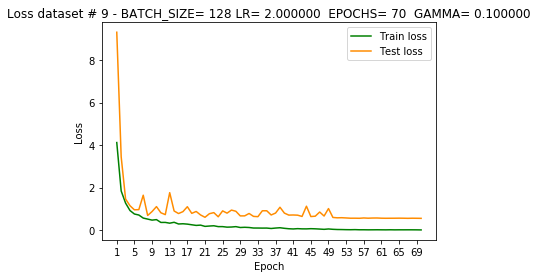

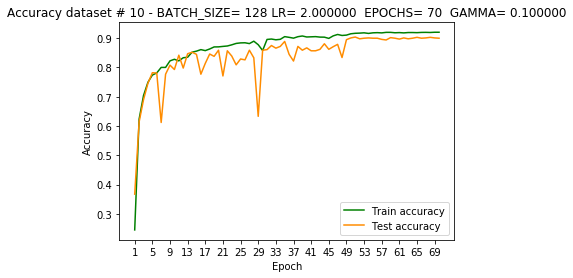

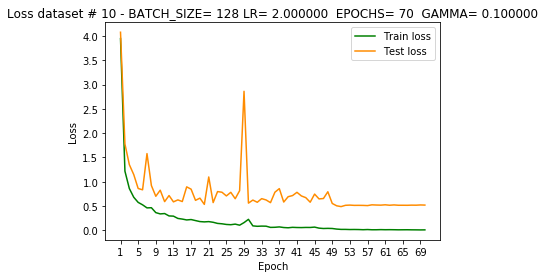

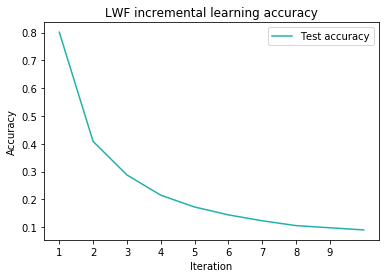

Accuracy last test [0.367, 0.614, 0.69, 0.746, 0.782, 0.781, 0.612, 0.777, 0.808, 0.793, 0.842, 0.798, 0.847, 0.852, 0.845, 0.777, 0.814, 0.846, 0.838, 0.859, 0.771, 0.857, 0.839, 0.809, 0.829, 0.826, 0.859, 0.833, 0.633, 0.859, 0.861, 0.875, 0.866, 0.872, 0.889, 0.845, 0.822, 0.872, 0.859, 0.867, 0.857, 0.857, 0.862, 0.881, 0.862, 0.871, 0.879, 0.834, 0.895, 0.901, 0.904, 0.898, 0.9, 0.901, 0.9, 0.9, 0.896, 0.894, 0.902, 0.9, 0.897, 0.901, 0.898, 0.9, 0.903, 0.9, 0.901, 0.903, 0.901, 0.9]


In [21]:
import matplotlib.pyplot as plt
parameters['name']='LWF'
parameters['GAMMA']=0.1


plot_lwf(new_acc_train_list, new_acc_test_list, new_loss_train_list, new_loss_test_list, all_acc_list, parameters)
